Replicating fastai caravana challenge notebook for datascience bowl

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys 

In [3]:
sys.path.append('../../fastai/')

In [4]:
from utility.utils import *

In [5]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
torch.cuda.set_device(1)

In [6]:
PATH = Path('../data/ds_bowl_2018/')
list(PATH.iterdir())

[PosixPath('../data/ds_bowl_2018/kaggle_fixed'),
 PosixPath('../data/ds_bowl_2018/csv'),
 PosixPath('../data/ds_bowl_2018/submissions'),
 PosixPath('../data/ds_bowl_2018/full_data')]

In [7]:
CSV_DN = 'csv'
TRAIN_DN = 'kaggle_fixed' 

In [8]:
CSV_FILES = list((PATH/CSV_DN).iterdir())

In [9]:
masks_csv = pd.read_csv(CSV_FILES[0])
masks_csv.head()

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


In [10]:
NUCLEI_ID = '58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd'

In [11]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('../data/ds_bowl_2018/kaggle_fixed/e4537e7893e631f3ba6ae5b1023e24b233c78249a31c2f5e561f6c4cad88fcf6'),
 PosixPath('../data/ds_bowl_2018/kaggle_fixed/c00ae67f72816daee468474026e30705003b2d3501f123579a4f0a6366b66aa1'),
 PosixPath('../data/ds_bowl_2018/kaggle_fixed/ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548'),
 PosixPath('../data/ds_bowl_2018/kaggle_fixed/d2815f2f616d92be35c7e8dcfe592deec88516aef9ffc9b21257f52b7d6d0354'),
 PosixPath('../data/ds_bowl_2018/kaggle_fixed/7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5')]

In [12]:
NUCLEI_IDS = [str(TRAIN_DIR).split('/')[-1] for TRAIN_DIR in list((PATH/TRAIN_DN).iterdir())]

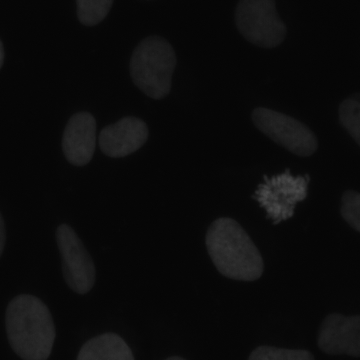

In [13]:
Image.open(PATH/TRAIN_DN/f'{NUCLEI_ID}/images/{NUCLEI_ID}.png')

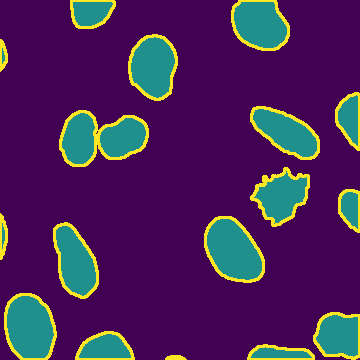

In [14]:
Image.open(PATH/TRAIN_DN/f'{NUCLEI_ID}/mclass_target.png')

In [15]:
ims = [open_image(PATH/TRAIN_DN/f'{NUCLEI_ID}/images/{NUCLEI_ID}.png')
       for NUCLEI_ID in NUCLEI_IDS[:16]]

In [16]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

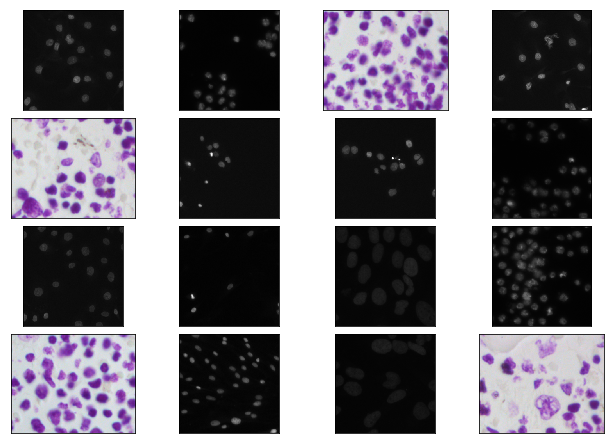

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

In [18]:
# TOTAL NUMBER OF IMAGES WITH MASK LABELS
n = len(list((PATH/TRAIN_DN).iterdir()))
n

664

### Data Prep

In [19]:
TRAIN_DN = Path('../data/ds_bowl_2018/kaggle_fixed/')

In [20]:
TRAIN_DIRS = list(TRAIN_DN.iterdir())

In [21]:
class FilesDataset(BaseDataset):
    def __init__(self, fnames, transform, path):
        self.path,self.fnames = path,fnames
        super().__init__(transform)
    def get_sz(self): return self.transform.sz
    def get_x(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_n(self): return len(self.fnames)

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [22]:
def get_multi_y(y, y_sz = None):
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    multi_y = np.dstack([(y == 30)*1,
    (y == 110)*1, 
    (y == 215)*1]).transpose(2,0,1)
    if y_sz is not None:
        multi_y = np.array([cv2.resize(y.astype(np.uint8), (y_sz, y_sz)) for y in multi_y])
    return multi_y.astype(np.float32)

class NucleiDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path, y_sz=256):
        self.y_sz = y_sz
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return get_multi_y(self.y[i], self.y_sz)
    def get_c(self): return 0

In [23]:
TRAIN_X = [str(x_name/'images'/x_name.name) + '.png' for x_name in TRAIN_DIRS]
TRAIN_Y = [str(x_name/'mclass_target.png') for x_name in TRAIN_DIRS]

In [24]:
# create trn, val data
from dataset.validation import *

classes = pd.read_csv('classes.csv')
train_dirs, valid_dirs = get_stratified_valid_dirs(classes, seed=17)

TRN_X = [s for s in TRAIN_X if s.split('/')[-1].split('.')[0] in train_dirs]
VAL_X = [s for s in TRAIN_X if s.split('/')[-1].split('.')[0] not in train_dirs]
TRN_Y = [s for s in TRAIN_Y if s.split('/')[-2] in train_dirs]
VAL_Y = [s for s in TRAIN_Y if s.split('/')[-2] not in train_dirs]

In [25]:
len(TRN_X), len(TRN_Y), len(VAL_X), len(VAL_Y)

(600, 600, 64, 64)

### Model Data

Using Imagenet stats or others

In [26]:
# set model function
PATH = '../data/'
f = resnet18
sz = 256
bs = 8

In [27]:
#stats = [0, 1] # no normalize
#tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=None) # non-imagenet stats
tfms = tfms_from_model(f, sz, crop_type=CropType.NO, tfm_y=None) # imagenet stats
dataset = ImageData.get_ds(NucleiDataset, (TRN_X, TRN_Y), (VAL_X, VAL_Y), tfms=tfms, path=PATH)
md = ImageData(PATH, dataset, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [28]:
x,y = next(iter(md.trn_dl))
x_np, y_np = to_np(x[0]), to_np(y[0])

In [29]:
x_np.min(), x_np.max()

(-1.9295317, 2.64)

In [30]:
open_image(TRN_X[0]).max()

0.5372549

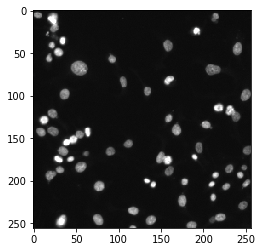

In [31]:
plt.imshow(denorm(x)[0])

### Check Data

In [32]:
x,y = next(iter(md.val_dl))

In [33]:
x_np = to_np(x[0])

In [34]:
y_np = to_np(y[0])

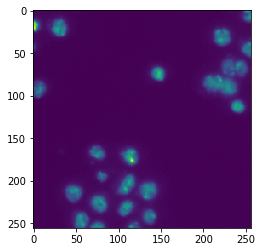

In [35]:
plt.imshow(x_np[1])

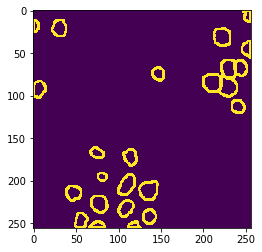

In [36]:
plt.imshow(y_np[2])

### Dyanmic UNET

In [37]:
from fastai.models.unet import *

In [38]:
# load defined model
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

### ENCODER: RESNET18

Has `extra_block` to output the original image size

Steps of creating a Dynamic Unet Model:

- Choose your encoder model or define it yourself (make sure it's downsampling as H, W -> H//2, W//2)
- Initialize DynamicUnet as m = DynamicUnet(encoder)
- In order to get the model to gpu set m = m.cuda()

In [39]:
f = resnet18
cut, cut_lr = model_meta[f]
cut, cut_lr

(8, 6)

In [40]:
encoder = get_encoder(f, cut)

In [41]:
m = DynamicUnet(encoder)

In [42]:
inp = torch.ones(1, 3, 256, 256)
out = m(V(inp))

In [43]:
out.size()

torch.Size([1, 3, 256, 256])

In [44]:
inp.size()

torch.Size([1, 3, 256, 256])

In [45]:
m

DynamicUnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=

### ENCODER: RESNET50

Has `extra_block` to output the original image size

In [46]:
f = resnet50
cut, cut_lr = model_meta[f]
cut, cut_lr

(8, 6)

In [47]:
encoder = get_encoder(f, cut)

In [48]:
m = DynamicUnet(encoder)

In [49]:
inp = torch.ones(1, 3, 256, 256)
out = m(V(inp))

In [50]:
out.size()

torch.Size([1, 3, 256, 256])

In [51]:
m

DynamicUnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e

### ENCODER: VGG16 

Doesn't have `extra_block`

In [52]:
f = vgg16
cut, cut_lr = model_meta[f]
cut, cut_lr

(0, 22)

In [53]:
encoder = get_encoder(f, 30)
m = DynamicUnet(encoder)

In [54]:
inp = torch.ones(1, 3, 256, 256)
out = m(V(inp))

In [55]:
out.size()

torch.Size([1, 3, 512, 512])

In [56]:
m

DynamicUnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

### Training Definitions

In [58]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.)

def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[...,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

def multi_acc(logits, targets):
    bs, c, h, w = logits.size()
    out2 = logits.view(bs,c,h*w).transpose(2,1).contiguous()
    input_ = out2.view(bs*h*w,c)

    # target for cross entropy
    _, idx = torch.max(targets, 1)
    target = idx.view(-1)

    return sum(torch.max(input_, dim=1)[1] == target) / len(target)

In [59]:
# since I am training on multiclass data, loss_fn will be different
class MulticlassBCELoss2d(nn.Module):
    """
    Weights for a single sample which is repeated along the batch
    Inputs:
        weight: weigth tensor for a single sample
    """
    def __init__(self):
        super(MulticlassBCELoss2d, self).__init__()
        
    def forward(self, logits, targets):
        # input for cross entropy
        bs, c, h, w = logits.size()
        out2 = logits.view(bs,c,h*w).transpose(2,1).contiguous()
        input_ = out2.view(bs*h*w,c)
        
        # target for cross entropy
        _, idx = torch.max(targets, 1)
        target = idx.view(-1)
        return F.cross_entropy(input_, target)

### Test Loss and Metric

In [60]:
targ = torch.stack([torch.ones(3,3)*0, torch.ones(3,3)*0, torch.ones(3,3)], dim=0)[None, :]
inp = torch.stack([torch.ones(3,3)*0.3, torch.ones(3,3)*0.3, torch.ones(3,3)*0.4], dim=0)[None, :]

In [61]:
# imagine all ground truth is class 2
# output logits are given
inp, targ

(
 (0 ,0 ,.,.) = 
   0.3000  0.3000  0.3000
   0.3000  0.3000  0.3000
   0.3000  0.3000  0.3000
 
 (0 ,1 ,.,.) = 
   0.3000  0.3000  0.3000
   0.3000  0.3000  0.3000
   0.3000  0.3000  0.3000
 
 (0 ,2 ,.,.) = 
   0.4000  0.4000  0.4000
   0.4000  0.4000  0.4000
   0.4000  0.4000  0.4000
 [torch.FloatTensor of size 1x3x3x3], 
 (0 ,0 ,.,.) = 
   0  0  0
   0  0  0
   0  0  0
 
 (0 ,1 ,.,.) = 
   0  0  0
   0  0  0
   0  0  0
 
 (0 ,2 ,.,.) = 
   1  1  1
   1  1  1
   1  1  1
 [torch.FloatTensor of size 1x3x3x3])

In [62]:
loss = MulticlassBCELoss2d()

In [63]:
loss(V(inp), V(targ))

Variable containing:
 1.0331
[torch.FloatTensor of size 1]

In [64]:
F.softmax(V(inp))

Variable containing:
(0 ,0 ,.,.) = 
  0.3220  0.3220  0.3220
  0.3220  0.3220  0.3220
  0.3220  0.3220  0.3220

(0 ,1 ,.,.) = 
  0.3220  0.3220  0.3220
  0.3220  0.3220  0.3220
  0.3220  0.3220  0.3220

(0 ,2 ,.,.) = 
  0.3559  0.3559  0.3559
  0.3559  0.3559  0.3559
  0.3559  0.3559  0.3559
[torch.FloatTensor of size 1x3x3x3]

In [65]:
# softmax(.., ..., 0.400) = (..., ..., 0.3559)
- np.log(0.3559)

1.03310548646599

In [66]:
multi_acc(inp, targ)

1.0

### Put everything together + Training (ResNet18)

#### 0) Define wrapper model class for Fast.ai Magic

In [67]:
# Wrap everything nicely
class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

#### 1) Define Encoder

In [137]:
f = vgg16
cut, cut_lr = model_meta[f]
cut, cut_lr

(0, 22)

#### 2) Specify Cut and Init DynamicUnet

Put model to gpu if you like

In [138]:
encoder = get_encoder(f, 30)
m = DynamicUnet(encoder)

# create a dummy input - I couldn't find a work around for this to co-op with cpu - gpu tensor weight
# incosistencies so it's best to make a single forward pass ourselves if we want to use the gpu
# otherwise it will be fine on cpu
inp = torch.ones(1,3,256,256)
out = m(V(inp))

In [139]:
out.size()

torch.Size([1, 3, 256, 256])

#### 3) Put to GPU (Optional) - Check Decoder Network

You will see `extra_block` for ResNet like architecture where downsample happens in first activation.

In [140]:
m.cuda(1)

DynamicUnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

#### 4) Wrap DynamicUnet to be Fast.ai Ready

`cut_lr` will be used to group layers for freezing

In [141]:
# specify layer groups pre-freezing
# cut_lr is experimental and heavily dependent on data you have, let's try 9
models = UpsampleModel(m, cut_lr=20)

#### 5) Create learn object

In [142]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit = MulticlassBCELoss2d()
learn.metrics=[multi_acc]

#### 6) Check your layers to make

In [143]:
learn.models.get_layer_groups(False)[1]

[Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace)]

In [144]:
# freeze first 3 conv bn relu
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▉ | 67/75 [00:16<00:01,  4.06it/s, loss=3.67] 

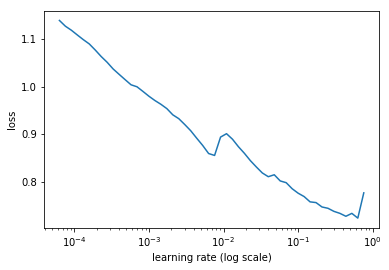

In [145]:
learn.lr_find()
learn.sched.plot()

In [146]:
lr = 0.1
learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

 39%|███▊      | 29/75 [00:07<00:11,  4.00it/s, loss=0.542]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/qipm/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/qipm/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/qipm/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   multi_acc                 
    0      0.365459   0.313083   0.900989  
    1      0.244834   0.201701   0.90635                   
    2      0.202497   0.143741   0.936129                  
    3      0.175733   0.124317   0.948842                  



[0.12431661318987608, 0.9488420486450195]

In [147]:
val_preds = learn.predict_dl(md.val_dl)

0


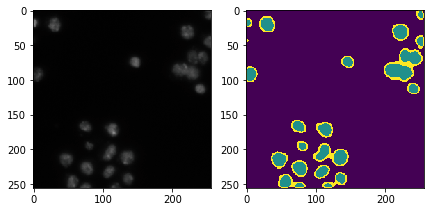

1


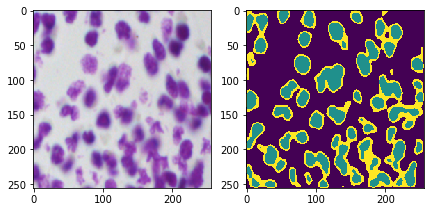

2


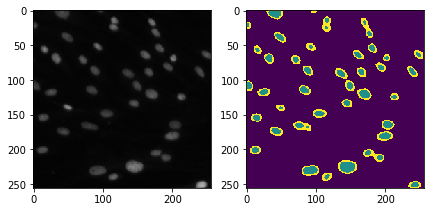

3


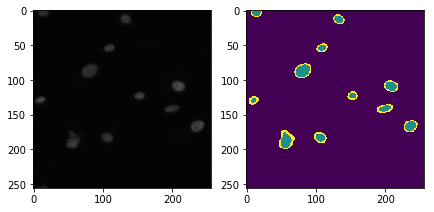

4


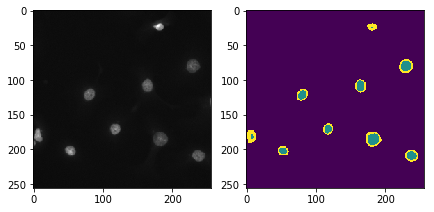

5


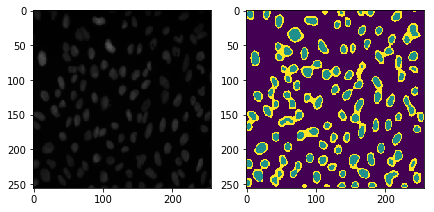

6


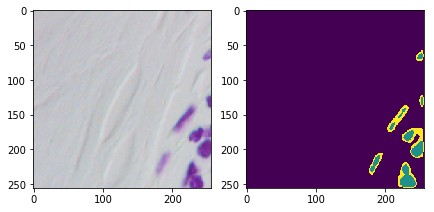

7


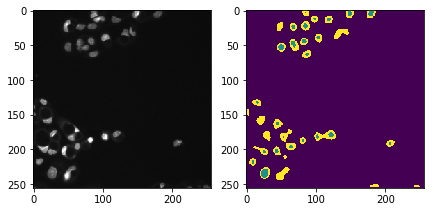

8


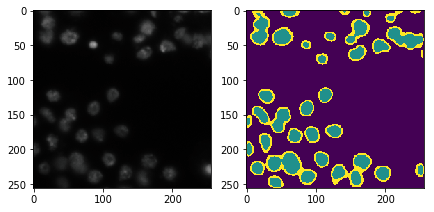

9


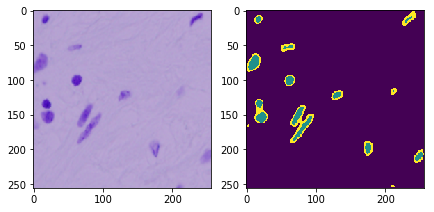

10


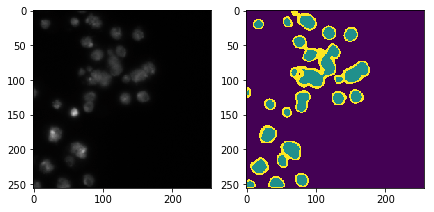

11


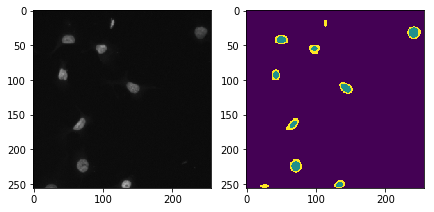

12


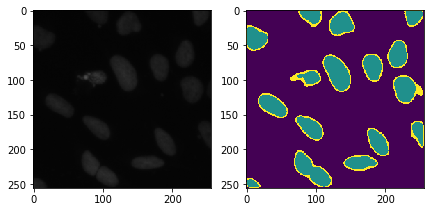

13


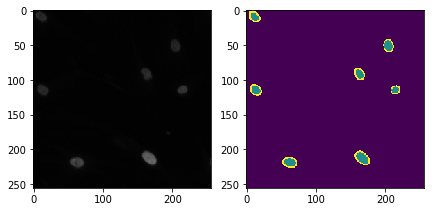

14


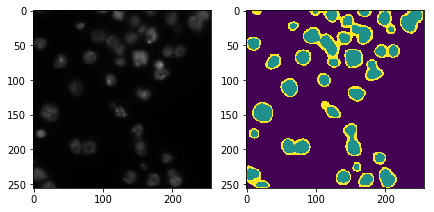

15


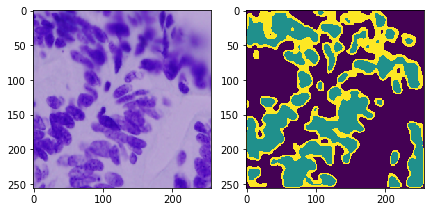

16


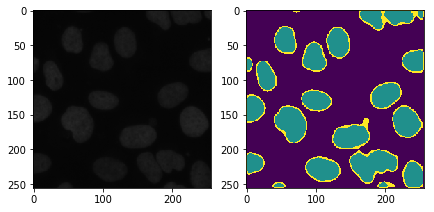

17


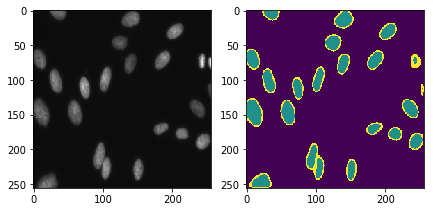

18


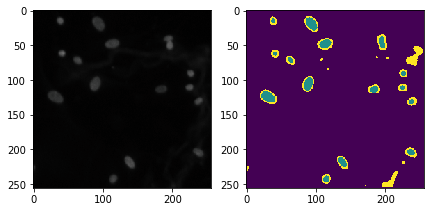

19


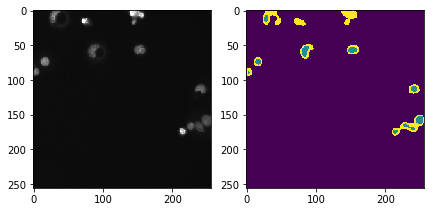

20


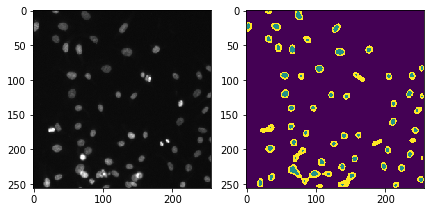

21


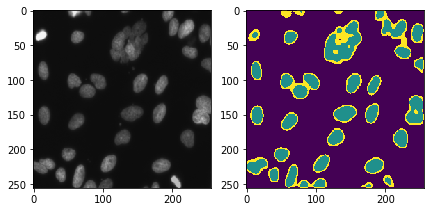

22


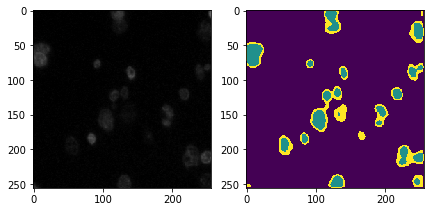

23


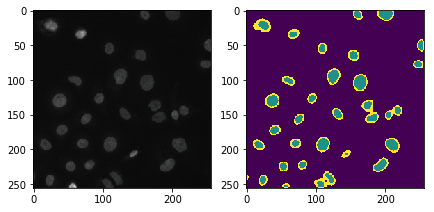

24


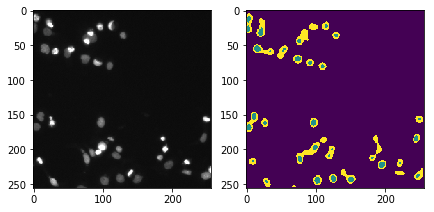

25


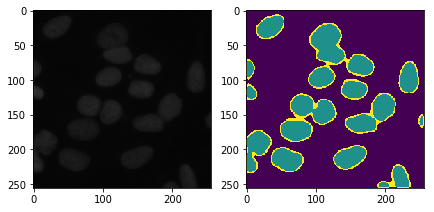

26


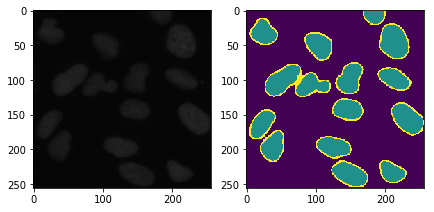

27


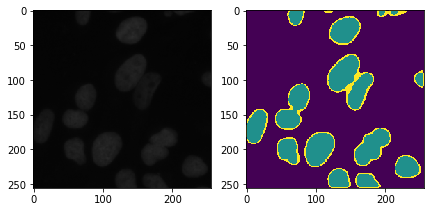

28


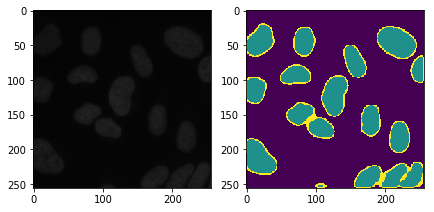

29


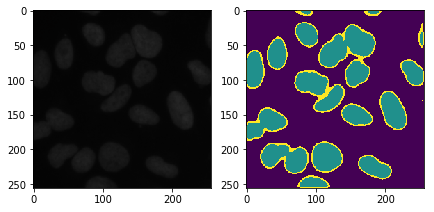

30


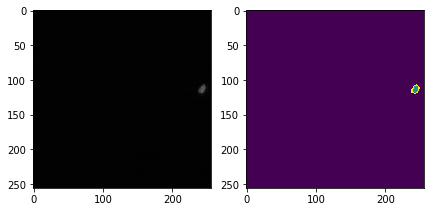

31


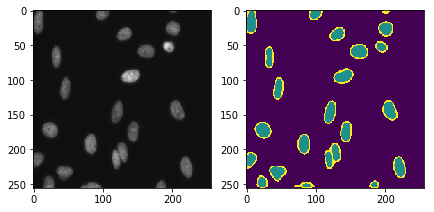

32


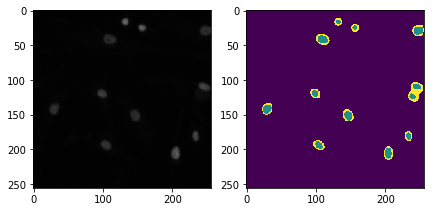

33


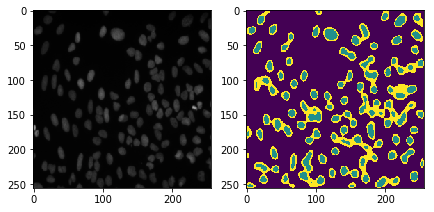

34


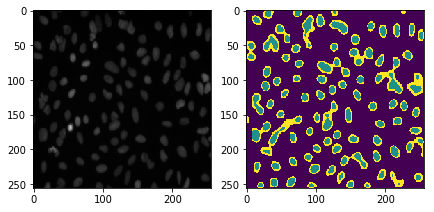

35


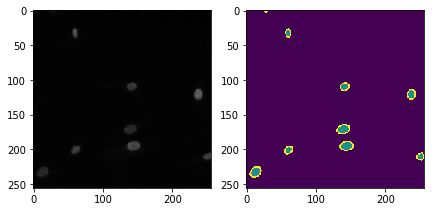

36


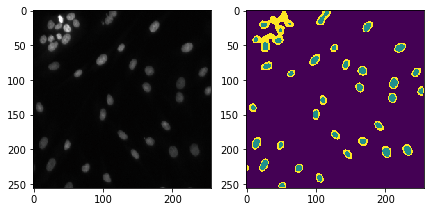

37


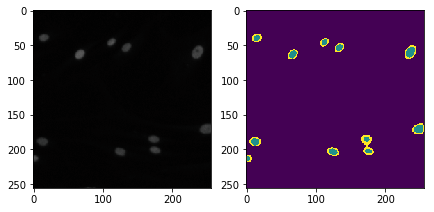

38


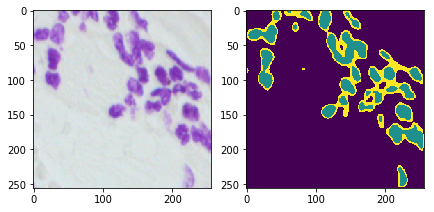

39


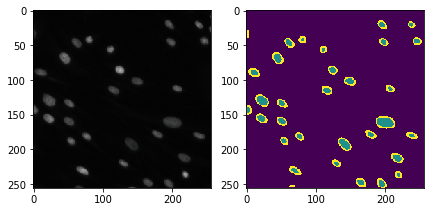

40


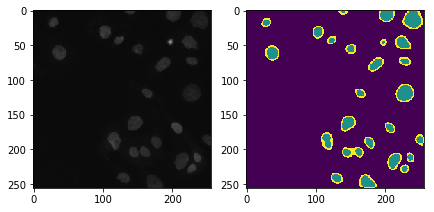

41


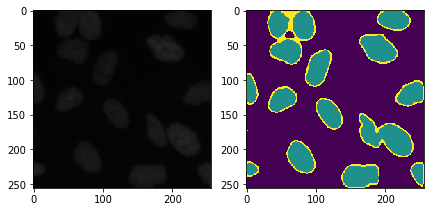

42


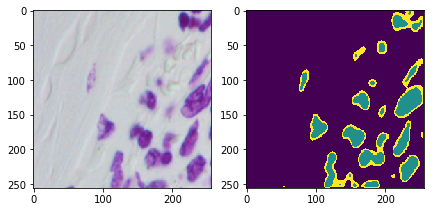

43


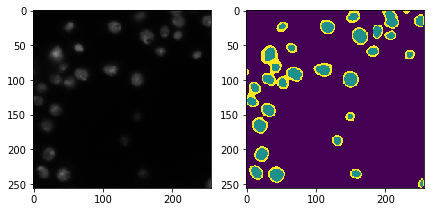

44


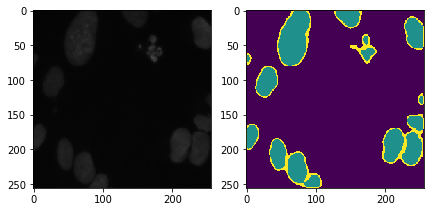

45


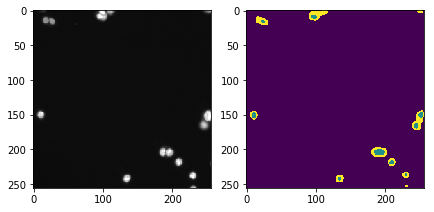

46


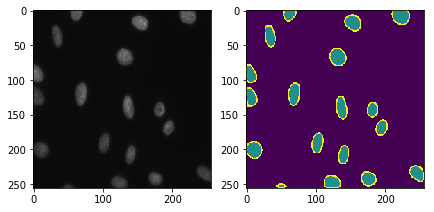

47


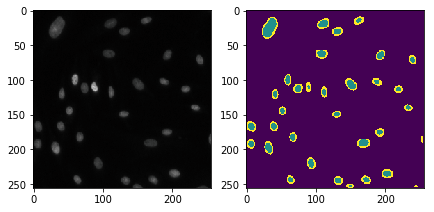

48


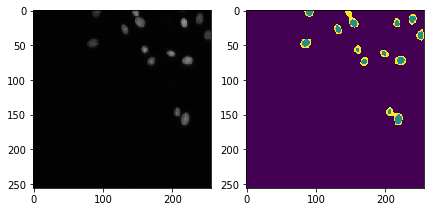

49


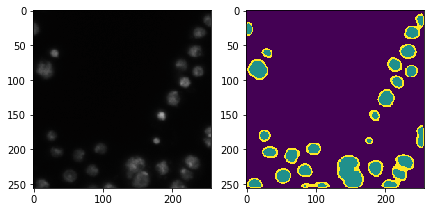

50


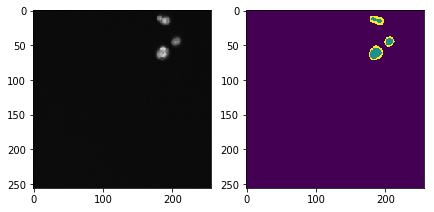

51


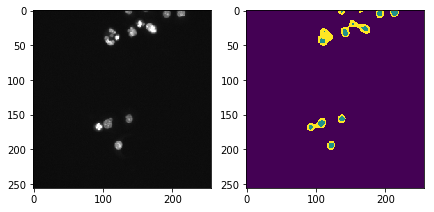

52


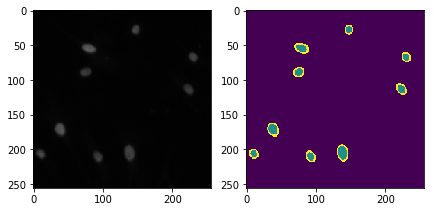

53


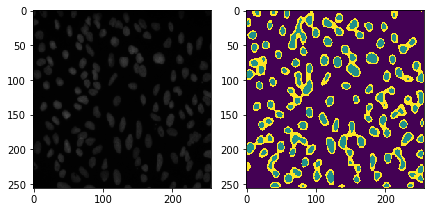

54


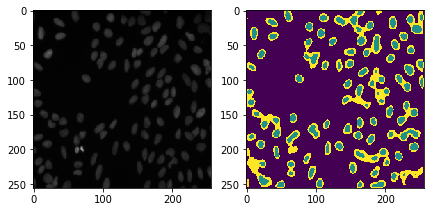

55


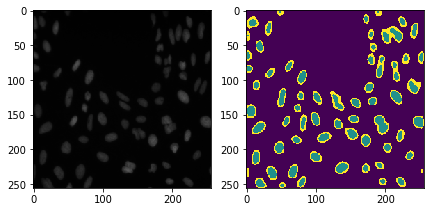

56


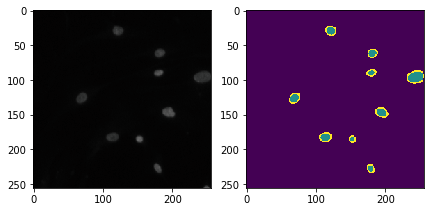

57


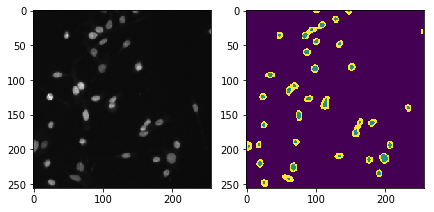

58


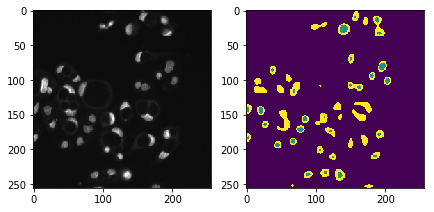

59


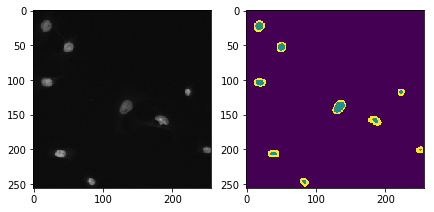

60


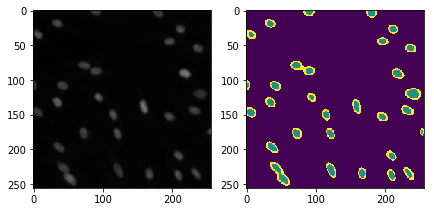

61


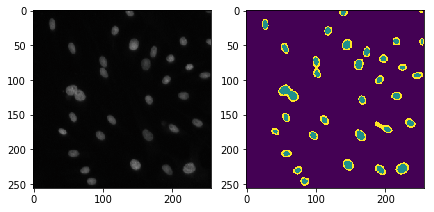

62


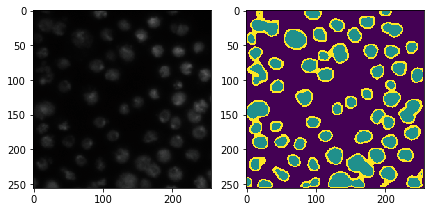

63


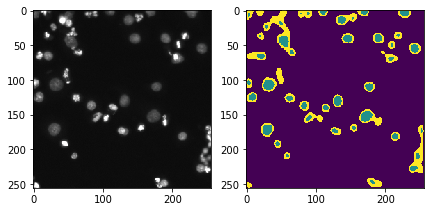

In [148]:
for i, pred in enumerate(val_preds):
    print(i)
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.imshow(denorm(md.val_ds.__getitem__(i)[0])[0])    
    plt.subplot(1,2,2)
    plt.imshow(np.argmax(pred, 0))    
    plt.show()

(array([   279.,   1324.,   3109., 182239.,   7281.,   1811.,    523.,     36.,      3.,      3.]),
 array([-3.70287e+26, -2.70755e+26, -1.71222e+26, -7.16899e+25,  2.78426e+25,  1.27375e+26,  2.26907e+26,
         3.26440e+26,  4.25972e+26,  5.25505e+26,  6.25037e+26]),
 <a list of 10 Patch objects>)

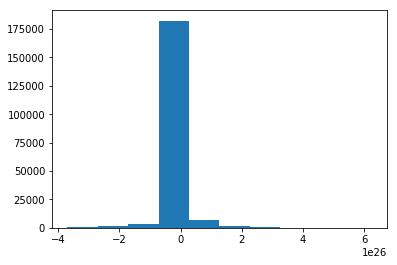

In [284]:
plt.hist(val_preds[30].flatten())

In [290]:
log_softmax = F.log_softmax(V(torch.FloatTensor(val_preds[30].flatten())))

In [291]:
F.nll_loss(log_softmax)

Variable containing:
-6.2504e+26
-6.2504e+26
-6.2504e+26
     ⋮     
-6.2504e+26
-6.2504e+26
-6.2504e+26
[torch.FloatTensor of size 196608]